# Mean-Variance Optimization of a portfolio - only risky assets

Here we will carry out the Mean Variance optimization for a portfolio containing multiple risky assets. First we will find the return and risk of two stocks from their price data. Then we plot the return and risk of arbitrarily weighted portfolios. We then design a mean-variance optimization function and plot the efficient frontier using it.

### Loading the necessary packages

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import scipy.optimize as sp
%matplotlib inline

### Obtaining the price data from Yahoo finance

In [ ]:
asset_list = []

start_date=input("please enter the start date:")
n=int(input("please enter the number of stocks:"))

for i in range(n):
    stock_i=(input("please enter the stock name:"))
    asset_list.append(stock_i)
print(asset_list)
price_data = pd.DataFrame()

for asset in asset_list:
    price_data[asset] = wb.DataReader(asset, data_source='yahoo', start=start_date)['Adj Close']

price_data.head()
price_data.type()

### Visualizing the relative performance of individual stocks

We scale the stock price data to be $100 on start_date and plot the price of each stock over time to visualize their relative performance. 

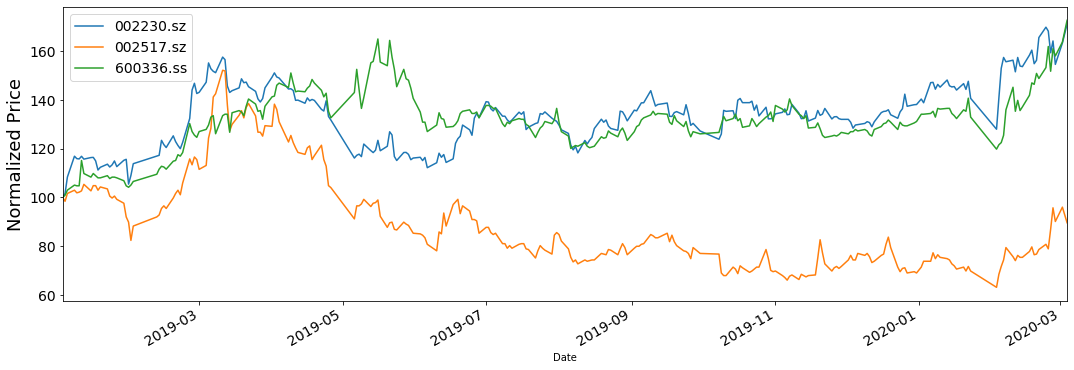

In [33]:
price_data_norm = price_data/price_data.iloc[0]*100

price_data_norm.plot(kind='line', figsize=(18, 6))
plt.xlabel('Date', size = 10)
plt.ylabel('Normalized Price', size = 18)
plt.tick_params(labelsize=14)
plt.legend(prop={'size': 14})

### Obtaining the Return of each stock and their covariance (annualized) from the logarithm returns

In [34]:
return_data = np.log(price_data/price_data.shift(1))

ret_array = return_data.mean()*250
print("The vector of mean asset returns (annualized):")
print(ret_array)

cov_matrix = return_data.cov()*250
print("The matrix of covariance of asset returns (annualized):")
print(cov_matrix)

The vector of mean asset returns (annualized):
002230.sz    0.481248
002517.sz   -0.098679
600336.ss    0.489369
dtype: float64
The matrix of covariance of asset returns (annualized):
           002230.sz  002517.sz  600336.ss
002230.sz   0.198597   0.124091   0.076919
002517.sz   0.124091   0.363934   0.084811
600336.ss   0.076919   0.084811   0.180023


### Obtaining the return and risk of random portfolios and plotting the efficient frontier

Here we obtain the return and volatility of 1000s of sample portfolios containing these two stocks randomly weighted. For each portfolio we calculate the return and volatility which we then append to a list. We then convert the lists into a Pandas dataframe and plot the return and risk of each portfolio.

Note: These are long only portfolios. This is not always an adequate assumption but is generally true for retail investors

In [35]:
iterations = 5000
pf_returns = []
pf_vol = []

In [36]:
for _ in range(iterations):
    weights = np.random.random(len(asset_list))
    weights /= sum(weights)
    pf_returns.append((np.sum(weights*ret_array))*100)
    pf_vol.append((np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights))))*100)

In [37]:
portfolios = pd.DataFrame({'Return': pf_returns, 'Volatility': pf_vol})
portfolios.head()

,Return,Volatility
0,44.764468,36.901385
1,33.422756,37.144958
2,36.639210,36.385322
3,14.840872,43.959203
4,29.356102,37.961492


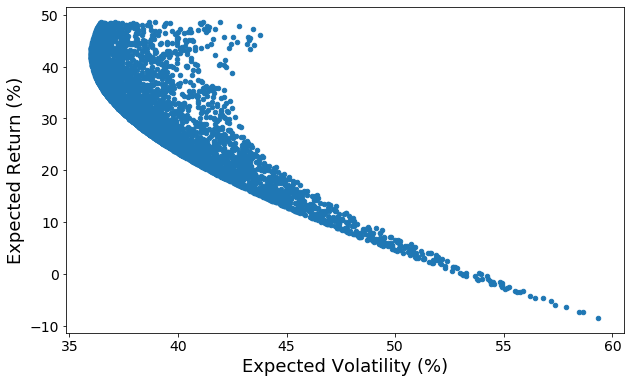

In [38]:
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6));
plt.xlabel('Expected Volatility (%)', size = 18)
plt.ylabel('Expected Return (%)', size = 18)
plt.tick_params(labelsize=14)

The Efficient Frontier is sort of visible here, but in the next section we would rigorously calculate it using a mean-variance optimization function. 

### The Mean-Variance Optimization Function: Markowitz(num_assets, means_in, covariance_in, target_ret)

This is a optimizer function to find the Markowitz efficient portfolio weights for long positions. It finds the portfolio weights for which the standard deviation (volatility) is minimized, given a target return. 

Input: 

       num_assets: number of assets in the portfolio

       means_in: numpy vector (1 x num_assets) of the portfolio's mean returns
       
       covariance_in: numpy matrix of the covariances (num_assets x num_assets)
       
       target_ret: the target return to be obtained
       
Output: The target return (target_ret) and the portfolio volatility (sol.fun)

Note: The output is not the portfolio weights but the minimum volatility. The function is designed for long-only portfolios. 
       

       

In [45]:
def Markowitz(num_assets, means_in, covariance_in, target_ret):
    
    #This is a optimizer function to find the Markowitz efficient portfolio weights (long positions only)
    
    #Input: num_assets: number of assets in the portfolio
    #       means_in: numpy vector (1 x num_assets) of the portfolio's mean returns
    #       covariance_in: numpy matrix of the covariances (num_assets x num_assets)
    #       target_ret: the target return to be obtained
    #       num_assets: number of assets in the portfolio
    
    ##Output: The target return (target_ret) and the portfolio volatility (sol.fun)
    
    ##Note: The procedure supports long positions only

    x_init = np.ones([num_assets])/num_assets

    def constraint_1(w):
        return np.dot(means_in,w) - target_ret

    def constraint_2(w):
        return np.sum(w) - 1.0

    def objective(w):
        return np.sqrt(np.dot(w,np.dot(covariance_in, w.T)))

    con1 = {'type':'eq', 'fun': constraint_1}
    con2 = {'type':'eq', 'fun': constraint_2}
    
    cons = [con1,con2]
    
    b = (0.0,1.0)
    bnds = (b,b,b)

    sol = sp.minimize(objective, x_init, method = 'SLSQP', bounds=bnds, constraints = cons)
    
    return(target_ret, sol.fun)

To use this function, we take target returns from 10% to 23% in steps of 0.1 %. Then we use the function for each of this target return to find the minimum velocity. This would be the efficient frontier

In [46]:
ret_vector = np.linspace(0.1, 0.4, num=200, endpoint=True)
std_vector = [Markowitz(len(asset_list), ret_array, cov_matrix, ret)[1] for ret in ret_vector]

We then plot the Efficient Portfolio along with the Return and Volatility calculated for the randomly weighted portfolios earlier

In [47]:
ret_vector = ret_vector*100.0
std_vector = np.array(std_vector)*100.0

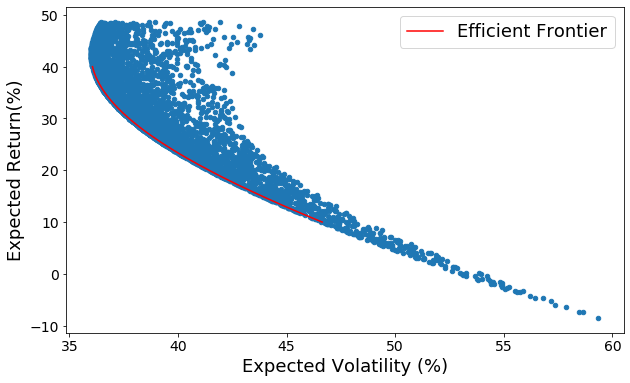

In [48]:
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6));
plt.plot(std_vector, ret_vector, 'r-', label = 'Efficient Frontier')
plt.xlabel('Expected Volatility (%)', size = 18)
plt.ylabel('Expected Return(%)', size = 18)
plt.legend(fontsize = 18)
plt.tick_params(labelsize=14)

### Plotting my current portfolio on the above plot to visualize its performance

In [49]:
weights_current = np.array([0.44,0.44,0.12])
ret_current = np.dot(ret_array,weights_current)*100.0
vol_current = np.sqrt(np.dot(weights_current,np.dot(cov_matrix, weights_current.T)))*100.0

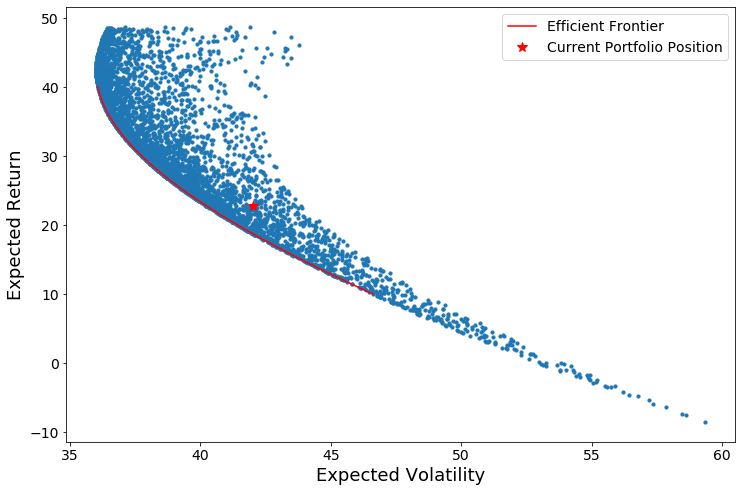

In [50]:
portfolios.plot.scatter(x='Volatility', y='Return', figsize=(12, 8), s=10);
plt.plot(std_vector, ret_vector, 'r-', label = 'Efficient Frontier')
plt.plot(vol_current, ret_current, 'r*', label = 'Current Portfolio Position', markersize = 10)
plt.xlabel('Expected Volatility', size = 18)
plt.ylabel('Expected Return', size = 18)
plt.legend(fontsize = 14)
plt.tick_params(labelsize=14)

So there is definitely some room for improvement and my portfolio should be adequately weighted to lie on the Efficient Frontier.